In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/eff-btrfly

/content/drive/MyDrive/Colab Notebooks/eff-btrfly


In [ ]:
!pip install --upgrade efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=0bb432b5f9e2fc4236646bd853810dcec4d28a4f49355a19116a9812598fcf2a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
#ambil arsitektur
from btrfly import BtrflyNet

In [ ]:
#load model
import torch

device = 'cuda'

kupu = BtrflyNet().to(device)
kupu.load_state_dict( torch.load('./kupu-model/model-btr0406a.pt') )

<All keys matched successfully>

In [ ]:
from PIL import Image
from torchvision import transforms

tfms = transforms.Compose([transforms.ToTensor()])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

imsize = (512, 128, 1)

def masking(msk):
    tmp = msk.round()
    return [(tmp == i).astype('float').tolist() for i in range(13)]

In [ ]:
import os

X, y = [], []

for name in os.listdir(f'./data/img'):
    if name[-5] == '1':
        X.append([
            tfms(Image.open(f'./data/img/{name[:-5]}1.png')).tolist(),
            tfms(Image.open(f'./data/img/{name[:-5]}2.png')).tolist()
        ])
        y.append([
            masking(plt.imread(f'./data/msk/{name[:-5]}1.png')[...,0] * 12),
            masking(plt.imread(f'./data/msk/{name[:-5]}2.png')[...,0] * 12)
        ])

vl = [ 6, 29,  0, 22, 34, 30,  4, 31]
tr = [i for i in range(37) if i not in vl]

X_train, X_valid = torch.Tensor( [X[i] for i in tr] ), torch.Tensor( [X[j] for j in vl] )
y_train, y_valid = torch.Tensor( [y[i] for i in tr] ), torch.Tensor( [y[j] for j in vl] )

#print(X)
n_data_train, n_data_valid = len(X_train), len(X_valid)

In [ ]:
def masking_torch(msk):
    return torch.Tensor([ (msk == i).cpu().numpy().astype('float') for i in range(13) ])

In [ ]:
import timeit

inp_size = (1,  3, 512, 128)
out_size = (1, 13, 512, 128)
dsc_size = (1, 1, 13, 512, 128)

start = timeit.default_timer()

with torch.no_grad():

    for i in range(n_data_train):
        
        x, y = X_train[i], y_train[i]
        
        out_ant, out_pos = kupu(
            x[0].reshape(inp_size).to(device),
            x[1].reshape(inp_size).to(device)
        )

        tmp = torch.cat([
            masking_torch(out_ant.argmax(axis=1)[0]).reshape(dsc_size),
            masking_torch(out_pos.argmax(axis=1)[0]).reshape(dsc_size)
        ], axis=1)

        if i == 0: y_predt = tmp + 0
        else: y_predt = torch.cat([y_predt, tmp], axis=0)

    for i in range(n_data_valid):
        
        x, y = X_valid[i], y_valid[i]
        
        out_ant, out_pos = kupu(
            x[0].reshape(inp_size).to(device),
            x[1].reshape(inp_size).to(device)
        )

        tmp = torch.cat([
            masking_torch(out_ant.argmax(axis=1)[0]).reshape(dsc_size),
            masking_torch(out_pos.argmax(axis=1)[0]).reshape(dsc_size)
        ], axis=1)

        if i == 0: y_predv = tmp + 0
        else: y_predv = torch.cat([y_predv, tmp], axis=0)

stop = timeit.default_timer()

print('Time: ', stop - start)

<ipython-input-9-89ed43dc3f24>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.Tensor([ (msk == i).cpu().numpy().astype('float') for i in range(13) ])


Time:  9.705835289999982


In [ ]:
cp = {
         0 : [1.0       , 1.0       , 1.0       ],
         1 : [0.6901961 , 0.9019608 , 0.05098039],
         2 : [0.        , 0.5921569 , 0.85882354],
         3 : [0.49411765, 0.9019608 , 0.8862745 ],
         4 : [0.6509804 , 0.21568628, 0.654902  ],
         5 : [0.9019608 , 0.6156863 , 0.7058824 ],
         6 : [0.654902  , 0.43137255, 0.3019608 ],
         7 : [0.47843137, 0.        , 0.09411765],
         8 : [0.22352941, 0.25490198, 0.72156864],
         9 : [0.9019608 , 0.85490197, 0.        ],
        10 : [0.9019608 , 0.44705883, 0.13725491],
        11 : [0.05098039, 0.7372549 , 0.24313726],
        12 : [0.9019608 , 0.7137255 , 0.08627451]
}

def map_clr(mask):
    res = []
    for row in mask:
        new_row = [cp[x] for x in row]
        res.append(new_row)
    return np.array(res)

16
16
16
16
9
9
9
9
17
17
17
17
13
13
13
13


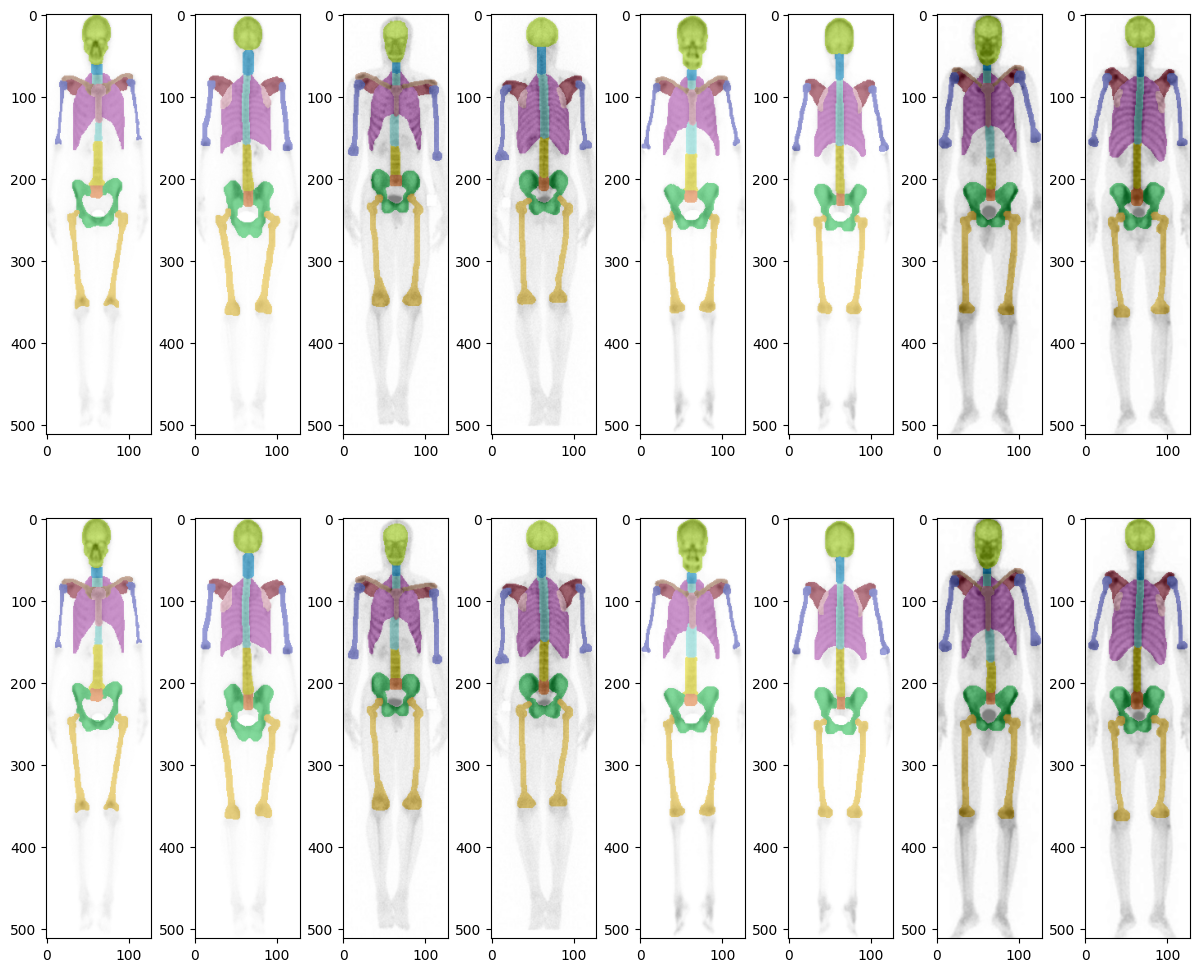

In [ ]:
#visualisasi data train & GT
n = 4
np.random.seed(76)
#sekuensial saja, jgn random ? [ 6, 29,  0, 22, 34, 30,  4, 31]
tr_idx = np.random.choice(range(n_data_train), n, False)
vl_idx = np.random.choice(range(n_data_valid), n, False)

#vl_idx =[6, 29, 0, 22, 34, 30, 4, 31]
plt.figure(figsize=(15, n*3))

for i in range(n):
    print(tr_idx[i])
    plt.subplot(2, n*2, (2*i)+1)
    plt.imshow(X_train[tr_idx[i]][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_predt[tr_idx[i]][0].argmax(axis=0).numpy()), alpha=0.5)

    print(tr_idx[i])
    plt.subplot(2, n*2, (2*i)+2)
    plt.imshow(X_train[tr_idx[i]][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_predt[tr_idx[i]][1].argmax(axis=0).numpy()), alpha=0.5)

    print(tr_idx[i])
    plt.subplot(2, n*2, (n*2)+(2*i)+1)
    plt.imshow(X_train[tr_idx[i]][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_train[tr_idx[i]][0].argmax(axis=0).numpy()), alpha=0.5)

    print(tr_idx[i])
    plt.subplot(2, n*2, (n*2)+(2*i)+2)
    plt.imshow(X_train[tr_idx[i]][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_train[tr_idx[i]][1].argmax(axis=0).numpy()), alpha=0.5)

#plt.savefig('./ujibtr0406a-1.png')

In [ ]:
#visualisasi 8 data uji
n=8
#print(vl_idx)
plt.figure(figsize=(60, n*3))
for i in range(n):
    
    plt.subplot(2, n*2, (2*i)+1)
    plt.imshow(X_valid[i][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_predv[i][0].argmax(axis=0).numpy()), alpha=0.5)
    
    plt.subplot(2, n*2, (2*i)+2)
    plt.imshow(X_valid[i][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_predv[i][1].argmax(axis=0).numpy()), alpha=0.5)
    
    plt.subplot(2, n*2, (n*2)+(2*i)+1)
    plt.imshow(X_valid[i][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_valid[i][0].argmax(axis=0).numpy()), alpha=0.5)
    
    plt.subplot(2, n*2, (n*2)+(2*i)+2)
    plt.imshow(X_valid[i][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_valid[i][1].argmax(axis=0).numpy()), alpha=0.5)

plt.savefig('./ujibtr-0406a-paper.png')

Output hidden; open in https://colab.research.google.com to view.

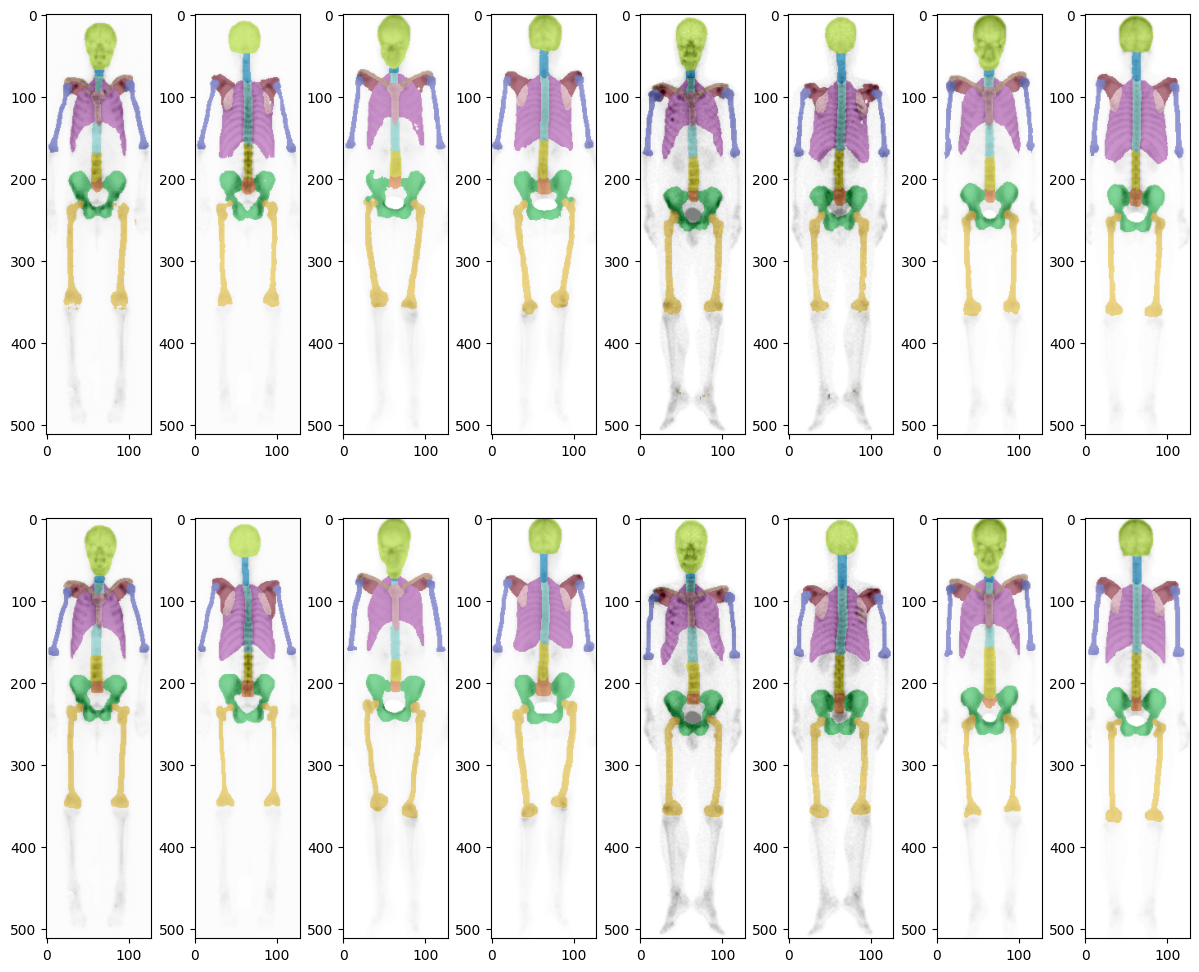

In [ ]:
#visualisasi data uji: 4
n=4
plt.figure(figsize=(15, n*3))
for i in range(n):
    #print(vl_idx[i])
    plt.subplot(2, n*2, (2*i)+1)
    plt.imshow(X_valid[i][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_predv[i][0].argmax(axis=0).numpy()), alpha=0.5)
    
    #print(vl_idx[i])
    plt.subplot(2, n*2, (2*i)+2)
    plt.imshow(X_valid[i][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_predv[i][1].argmax(axis=0).numpy()), alpha=0.5)
    
    #print(vl_idx[i])
    plt.subplot(2, n*2, (n*2)+(2*i)+1)
    plt.imshow(X_valid[i][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_valid[i][0].argmax(axis=0).numpy()), alpha=0.5)
    
    #print(vl_idx[i])
    plt.subplot(2, n*2, (n*2)+(2*i)+2)
    plt.imshow(X_valid[i][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_valid[i][1].argmax(axis=0).numpy()), alpha=0.5)

    #####################################################################




#plt.savefig('./ujibtr0406a-2.png')

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true[:,:,1:,:,:].flatten()
    y_pred_f = y_pred[:,:,1:,:,:].flatten()
    union = y_true_f.flatten().sum().item() + y_pred_f.flatten().sum().item()
    if union == 0: return 1
    intersection = (y_true_f * y_pred_f).sum().item()
    return 2 * intersection / union

dice_coef(y_train, y_predt)

0.9959567417274211

In [ ]:
dice_coef(y_valid, y_predv)

0.8853067467286013

In [ ]:
def dice_coef_all(y_true, y_pred):
    dice_scores = []
    for i in range(1,13):
        y_true_f = y_true[:,:,i,:,:].flatten()
        y_pred_f = y_pred[:,:,i,:,:].flatten()
        union = y_true_f.flatten().sum().item() + y_pred_f.flatten().sum().item()
        if union == 0:
            dice_scores.append(1)
        else:
            intersection = (y_true_f * y_pred_f).sum().item()
            dice_scores.append(2 * intersection / union)
    return dice_scores

In [ ]:
import pandas as pd

segments = [
    'Skull (Green)',
    'Cervical Vertebrae (Blue)',
    'Thoracic Vertebrae (Light Blue)',
    'Ribs (Purple)',
    'Sternum (Pink)',
    'Clavicle (Light Brown)',
    'Scapula (Dark Brown)',
    'Humerus (Dark Blue)',
    'Lumbar Vertebrae (Yellow)',
    'Sacrum (Orange)',
    'Pelvis (Dark Green)',
    'Femur (Gold)'
]

pd.DataFrame({
    'Segment'    : segments,
    'Dice Score' : dice_coef_all(y_valid, y_predv)
})

#sternum tidak ada di posterior. Saat segmentasi nilainya akan diset 1 oleh program; harus di-exclude saat penghitungan dice score rata-rata

,Segment,Dice Score
0,Skull (Green),0.950292
1,Cervical Vertebrae (Blue),0.770796
2,Thoracic Vertebrae (Light Blue),0.848799
3,Ribs (Purple),0.911755
4,Sternum (Pink),0.837679
5,Clavicle (Light Brown),0.793636
6,Scapula (Dark Brown),0.840769
7,Humerus (Dark Blue),0.860351
8,Lumbar Vertebrae (Yellow),0.873461
9,Sacrum (Orange),0.816249


## **ANTERIOR**

In [21]:
def dice_coef_section(y_true, y_pred, sec):
    sec = {'ant' : 0, 'pos' : 1}[sec]
    dice_scores = []
    for i in range(1,13):
        y_true_f = y_true[:,sec,i,:,:].flatten()
        y_pred_f = y_pred[:,sec,i,:,:].flatten()
        union = y_true_f.flatten().sum().item() + y_pred_f.flatten().sum().item()
        if union == 0:
            dice_scores.append(1)
        else:
            intersection = (y_true_f * y_pred_f).sum().item()
            dice_scores.append(2 * intersection / union)
    return dice_scores

# anterior
pd.DataFrame({
    'Segment'    : segments,
    'Dice Score' : dice_coef_section(y_valid, y_predv, 'ant')
})

,Segment,Dice Score
0,Skull (Green),0.944502
1,Cervical Vertebrae (Blue),0.431579
2,Thoracic Vertebrae (Light Blue),0.773423
3,Ribs (Purple),0.913465
4,Sternum (Pink),0.849724
5,Clavicle (Light Brown),0.793636
6,Scapula (Dark Brown),0.820294
7,Humerus (Dark Blue),0.859568
8,Lumbar Vertebrae (Yellow),0.837706
9,Sacrum (Orange),0.771448


## **POSTERIOR**

In [23]:
# posterior
pd.DataFrame({
    'Segment'    : segments,
    'Dice Score' : dice_coef_section(y_valid, y_predv, 'pos')
})

,Segment,Dice Score
0,Skull (Green),0.958392
1,Cervical Vertebrae (Blue),0.839362
2,Thoracic Vertebrae (Light Blue),0.898740
3,Ribs (Purple),0.910351
4,Sternum (Pink),0.826380
5,Clavicle (Light Brown),1.000000
6,Scapula (Dark Brown),0.852619
7,Humerus (Dark Blue),0.861137
8,Lumbar Vertebrae (Yellow),0.907216
9,Sacrum (Orange),0.842422
